In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [2]:
sc._settings.ScanpyConfig.n_jobs = -1

In [2]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [3]:
df = pd.read_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/Maps_data/cHL_CODEX/quantification/cHL_CODEX_annotation.csv')

In [4]:
df

,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,...,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,...,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,...,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,...,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686
3,4,2899,3,64,Monocyte,0.000000,0.012896,0.287698,0.268121,0.000000,...,0.052713,0.005982,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151
4,5,3657,3,61,CD4,0.201057,0.110590,0.000000,0.000000,0.000000,...,0.026865,0.011771,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145156,152811,2882,8004,119,Neutrophil,0.000000,0.523642,1.000000,0.182044,1.000000,...,0.205187,0.098993,0.790734,0.878804,0.067239,0.082646,0.671506,0.455424,0.0,0.040877
145157,152812,2893,8004,82,Neutrophil,0.000000,0.210238,0.313372,0.076860,0.986128,...,0.211576,0.143761,0.801359,0.500603,0.069040,0.077637,0.327586,1.000000,0.0,0.068794
145158,152813,2327,8004,92,Other,0.000000,0.620555,0.000089,0.025792,0.000029,...,0.332249,0.051137,1.000000,0.752380,0.806268,0.250223,1.000000,0.462049,0.0,0.086740
145159,152814,3371,8003,184,CD4,0.000000,0.597890,0.000000,0.099606,0.000029,...,0.302916,0.138358,1.000000,0.899182,0.362010,0.142534,0.086661,0.963140,0.0,0.167498


In [5]:
columns = df.columns.tolist()
new_order = columns[5:] + columns[:5]
df = df[new_order]
df.rename(columns={'cellType': 'cell_type'}, inplace=True)
df.drop(columns=['X_cent', 'Y_cent', 'cellLabel'], inplace=True)
df = df[df['cell_type'] != 'Seg Artifact']

In [6]:

df.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/Maps_data/cHL_CODEX/quantification/processed/cHL_CODEX_cleaned.csv', index=False)

In [33]:
X_columns = df.columns[:df.columns.get_loc('cellSize')]
obs_columns = df.columns[df.columns.get_loc('cellSize'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [18]:
adata.X.max()

1.0

In [25]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


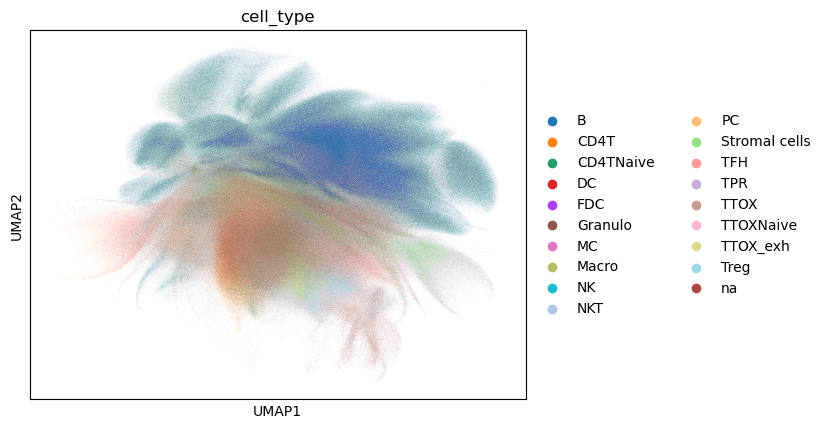

In [18]:
sc.pl.umap(adata, color='cell_type')

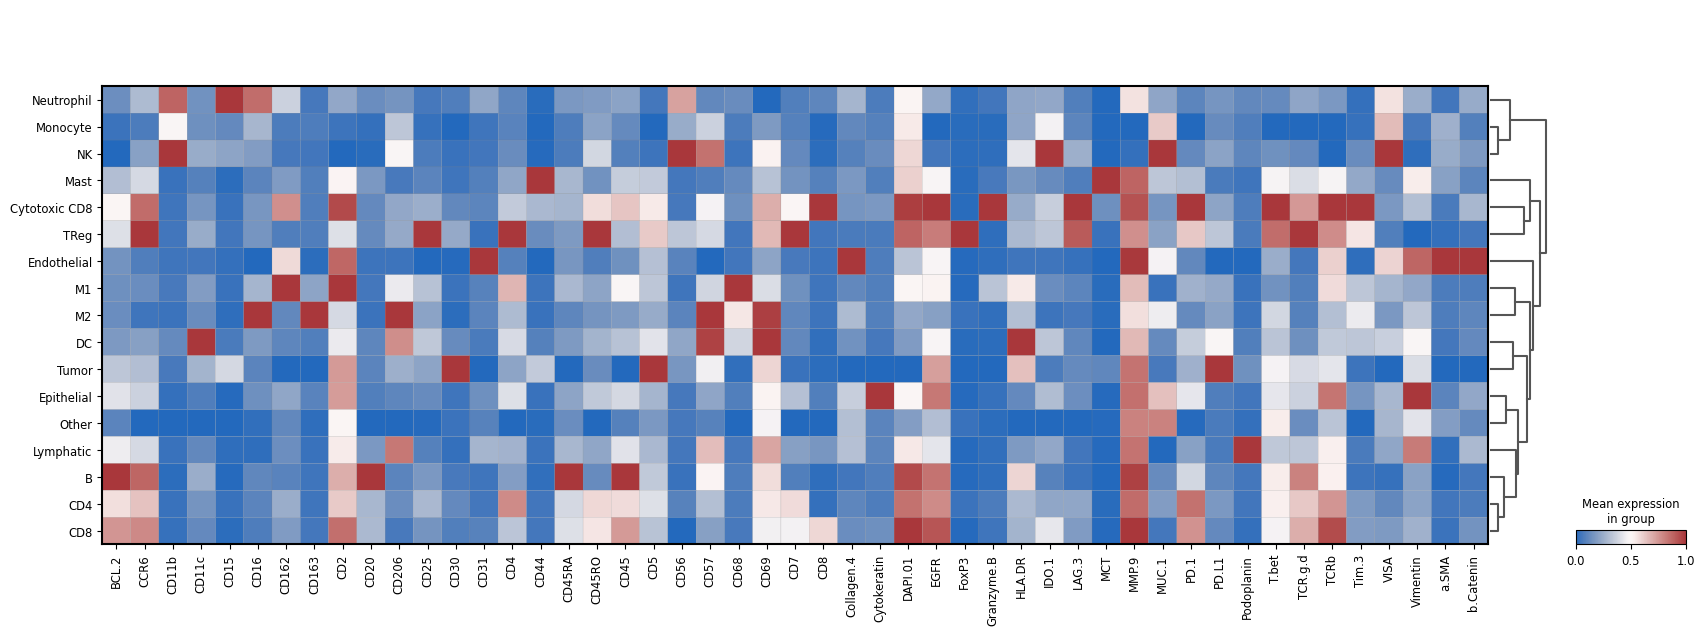

In [34]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, standard_scale='var')

NK cell CD11b and IDO1 do not make much sense

In [29]:
adata.obs['cell_type'].value_counts()

cell_type
CD4              37480
CD8              17184
B                16196
DC                9637
Endothelial       8705
Tumor             8260
NK                7339
M2                7286
Monocyte          6913
Other             5108
Lymphatic         3768
Neutrophil        3442
TReg              3352
Mast              3324
M1                3101
Epithelial        2251
Seg Artifact      1431
Cytotoxic CD8      384
Name: count, dtype: int64

In [21]:
sc.tl.rank_genes_groups(adata, groupby='cell_type' , method='wilcoxon')

In [22]:
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.2, max_out_group_fraction = 1, key = 'rank_genes_groups', key_added='rank_genes_groups_filtered')

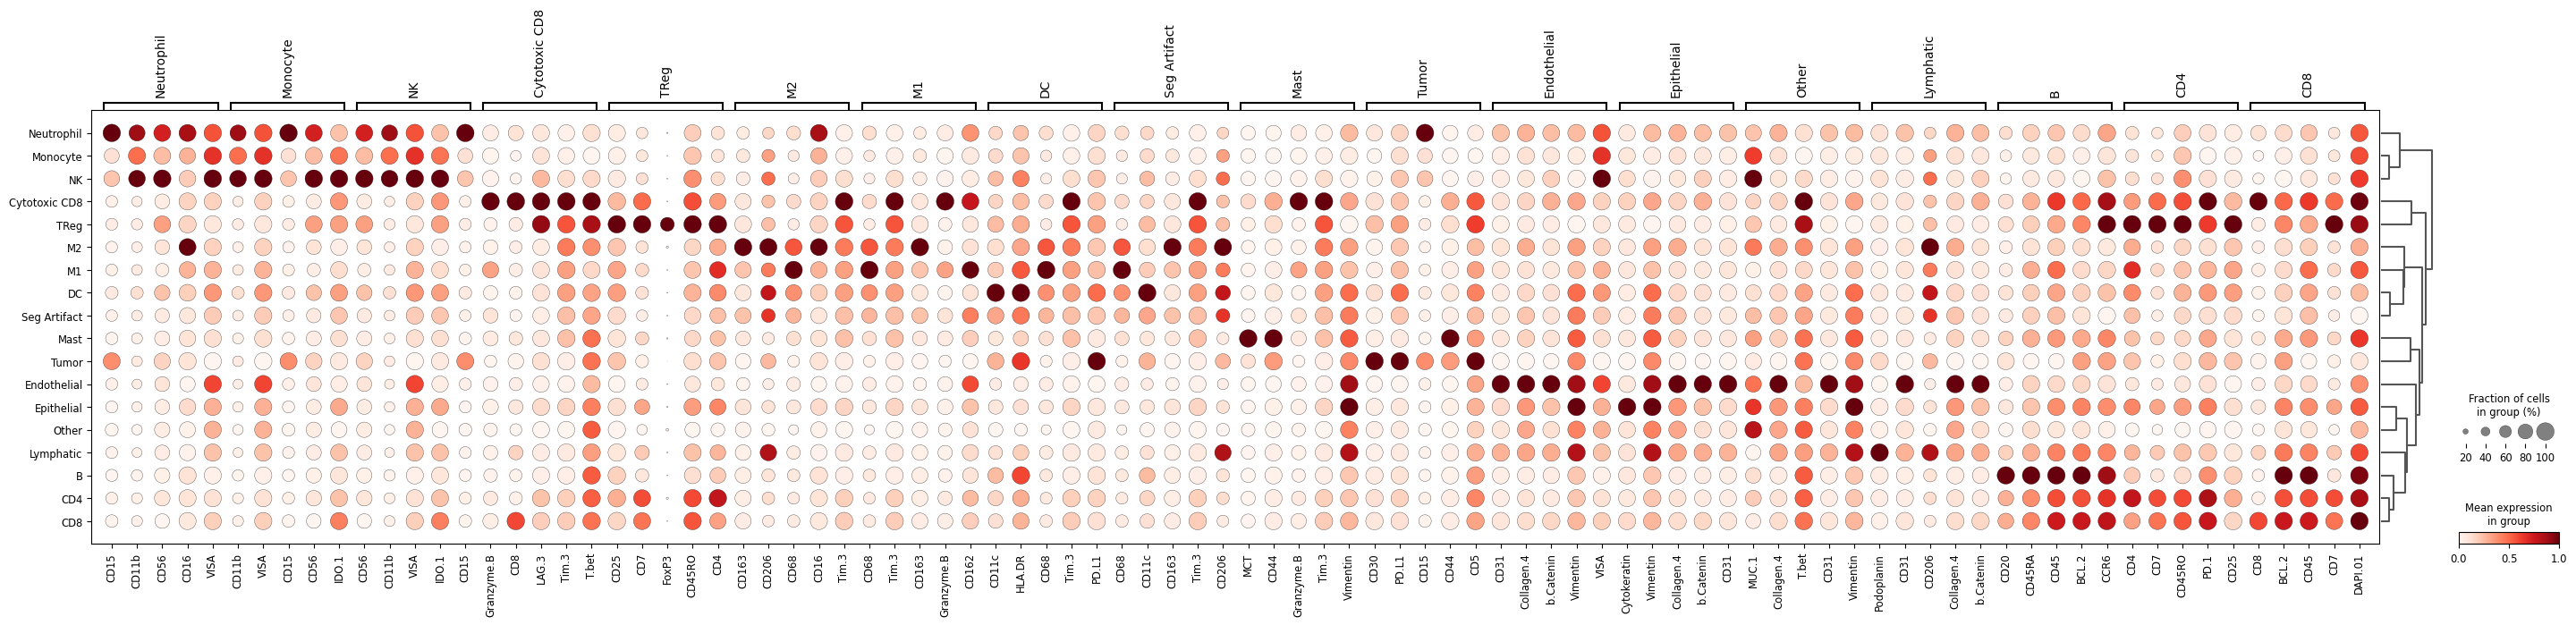

In [23]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups')

categories: B, CD4, CD8, etc.
var_group_labels: B, CD4, CD8, etc.


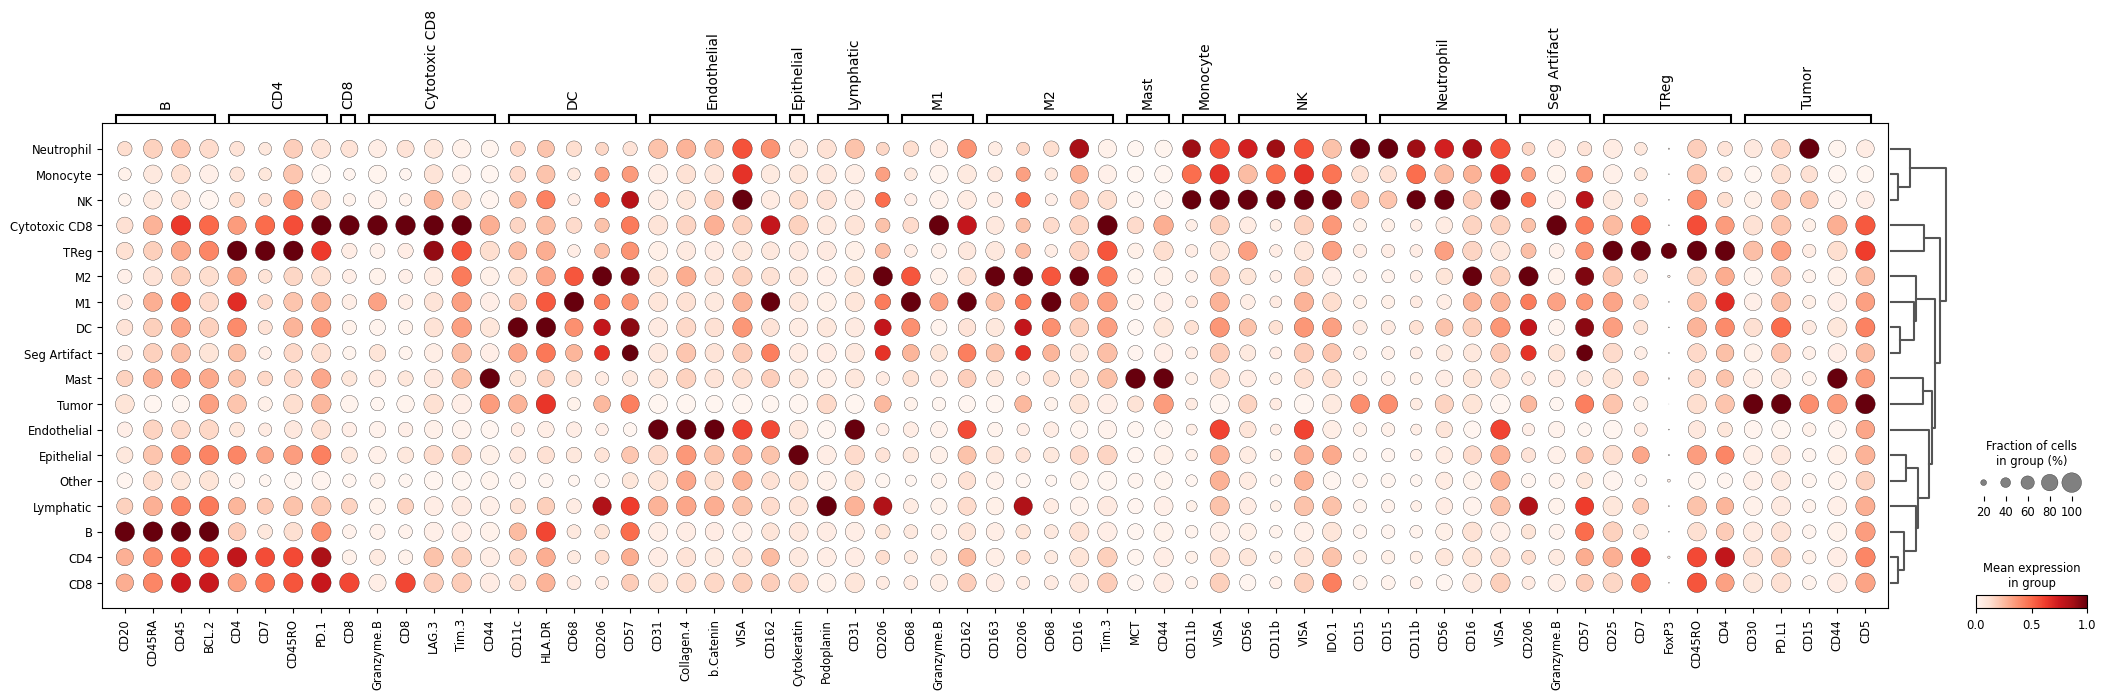

In [24]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups_filtered')